##  Amazon Fine Food Reviews Analysis

### The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.
* Number of reviews: 568,454
* Number of users: 256,059
* Number of products: 74,258
* Timespan: Oct 1999 - Oct 2012
* Number of Attributes/Columns in data: 10

### Attribute Information:
* Id
* ProductId - unique identifier for the product
* UserId - unqiue identifier for the user
* ProfileName
* HelpfulnessNumerator - number of users who found the review helpful
* HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
* Score - rating between 1 and 5
* Time - timestamp for the review
* Summary - brief summary of the review
* Text - text of the review

### Objective:

Run NB Algorithms on Amazon Fine Foods Review Dataset using BoW,TF-IDF vectorization methods. Also report the various performance metrics and find the feature importance for each class labels. Time based splitting to be followed.

### Importing the libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn import cross_validation
import string
import sqlite3
from sklearn.metrics import confusion_matrix
import re
import pickle
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer



C:\Users\abc\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Loading the Dataset

In [2]:
con = sqlite3.connect('F:/Applied AI Course/Amazon fine food review dataset/database.sqlite')

In [3]:
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

### Removing the duplicates

In [4]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

In [5]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [6]:
final.shape

(364171, 10)

### Creating a subset of the data

In [9]:
final=final.iloc[:100000,:]

In [10]:
final.shape

(100000, 10)

In [11]:
final = final.sort_values('Time',axis=0,kind="quicksort", ascending=True,inplace=False).reset_index(drop=True)

In [12]:
final['Score'].value_counts()

positive    85197
negative    14803
Name: Score, dtype: int64

### Data Preprocessing

In [42]:
import re
import nltk
stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub('[^A-Za-z0-9]+','',sentence)
    return  cleaned


print(sno.stem('tasty'))

tasti


In [43]:
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [44]:
final['CleanedText']=final_string

In [45]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
3,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
4,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...


In [46]:
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [47]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
3,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
4,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [49]:
final.to_pickle('100k_nb1_data.pkl')

In [2]:
final=pd.read_pickle('100k_nb1_data.pkl')

In [26]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,encoded_labels
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,1
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,1
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,1
3,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,1
4,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,1


In [3]:
X = final["CleanedText"]
y = final["Score"]

In [4]:
import math
X_1=X[:math.ceil(len(final)*.8)]
y_1=y[:math.ceil(len(final)*.8)]
X_test=X[math.ceil(len(final)*.8):]
y_test=y[math.ceil(len(final)*.8):]

print(X_1.shape,y_1.shape,X_test.shape)

(80000,) (80000,) (20000,)


In [5]:
X_train=X_1[:math.ceil(len(final)*.6)]
y_train=y_1[:math.ceil(len(final)*.6)]
X_CV=X_1[math.ceil(len(final)*.6):]
y_CV=y_1[math.ceil(len(final)*.6):]

print(X_train.shape,y_train.shape,X_CV.shape)

(60000,) (60000,) (20000,)


### Perform Naive Bayes using BOW and calculate 'alpha'

In [6]:
from sklearn.naive_bayes import MultinomialNB

In [11]:
from sklearn.metrics import f1_score

In [7]:
count_vect = CountVectorizer() #in scikit-learn
X_train = count_vect.fit_transform(X_train)

In [8]:
X_test = count_vect.transform(X_test)
X_CV=count_vect.transform(X_CV)

In [9]:
X_train

<60000x46621 sparse matrix of type '<class 'numpy.int64'>'
	with 1815946 stored elements in Compressed Sparse Row format>

In [10]:
neighbors = [10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3]

In [13]:
cv_scores = []

   
for k in neighbors:
    nb = MultinomialNB(alpha=k)
     # fitting the model on crossvalidation train
    nb.fit(X_train, y_train)
    # predict the response on the crossvalidation train
    pred = nb.predict(X_CV)
     # evaluate CV accuracy
    f1_value = f1_score(y_CV, pred, average='weighted') * float(100)
    cv_scores.append(f1_value)
    print('\nCV F1-Scores for alpha = %f is %d%%' % (k, f1_value))


CV F1-Scores for alpha = 0.001000 is 87%

CV F1-Scores for alpha = 0.010000 is 87%

CV F1-Scores for alpha = 0.100000 is 88%

CV F1-Scores for alpha = 1.000000 is 88%

CV F1-Scores for alpha = 10.000000 is 75%

CV F1-Scores for alpha = 100.000000 is 74%

CV F1-Scores for alpha = 1000.000000 is 74%


In [14]:
MSE = [100 - x for x in cv_scores]

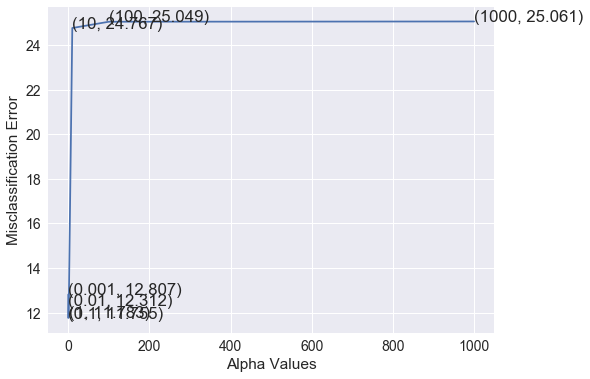

the misclassification error for each alpha value is :  [ 12.807  12.312  11.755  11.783  24.767  25.049  25.061]


In [33]:
plt.figure(figsize=(8,6))
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Alpha Values')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each alpha value is : ", np.round(MSE,3))

In [15]:
optimal_alpha = neighbors[MSE.index(min(MSE))]
print('\nThe optimal value of alpha is %f.' % optimal_alpha)


The optimal value of alpha is 0.100000.


In [16]:
nb = MultinomialNB(alpha=optimal_alpha)
nb.fit(X_train, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [17]:
pred = nb.predict(X_test)

In [22]:
f1_value = f1_score(y_test, pred,average='weighted') * float(100)
print('\nThe F1-Score of the nb classifier for alpha = %f is %f%%' % (optimal_alpha, f1_value))


The F1-Score of the nb classifier for alpha = 0.100000 is 87.500061%


In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [29]:
array=confusion_matrix(y_test, pred)

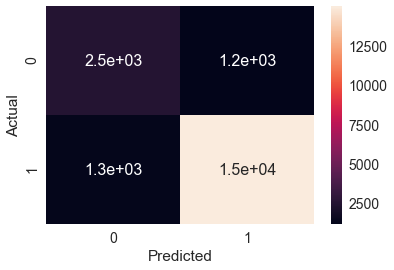

In [30]:
df_cm = pd.DataFrame(array, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### confusion matrix described

In above confusion matrix(used to describe performence of classifier)

* tn(true negative) = 2500, tp(true positive) = 15000, fn(false negative) = 1300, fp(false positive) = 1200
* precision --> When it predicts +ve, how often is it correct? = tp/predicted +ve = 15000/16200 = ~92.5%
* True Positive rate(tpr)/recall --> When it is actually +ve, how often does it predict +ve? = tp/(real/true/actual +ve) = 15000/16300 = ~92.20%
* Specificity(True Negative Rate)--> When it's actually no, how often does it predict no? = tn/actual negative = 2500/3700 = ~67.5%.
* False Positive rate --> when it is actually -ve, how often does it predicted +ve = fp/actual-ve = 1200/3700 = ~32.4%


### Feature importance for both +ve and -ve class 

In [34]:
new_final=pd.concat([X,y],ignore_index=False,axis=1)

In [35]:
new_final.shape

(100000, 2)

In [36]:
new_final.head()

,CleanedText,Score
0,witti littl book make son laugh loud recit car...,positive
1,rememb see show air televis year ago child sis...,positive
2,beetlejuic well written movi everyth excel act...,positive
3,twist rumplestiskin captur film star michael k...,positive
4,beetlejuic excel funni movi keaton hilari wack...,positive


In [37]:
def partition(x):
    if x == 'positive':
        return 1
    return 0

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = new_final['Score']
Zero_one = actualScore.map(partition) 
new_final['Actual_Score'] = Zero_one

In [38]:
new_final.head()

,CleanedText,Score,Actual_Score
0,witti littl book make son laugh loud recit car...,positive,1
1,rememb see show air televis year ago child sis...,positive,1
2,beetlejuic well written movi everyth excel act...,positive,1
3,twist rumplestiskin captur film star michael k...,positive,1
4,beetlejuic excel funni movi keaton hilari wack...,positive,1


In [39]:
X1=X_train

In [40]:
y1=new_final['Actual_Score']
y1=y1[:60000]

In [41]:
all_features=count_vect.get_feature_names()
all_nd_features=np.array(all_features)

In [42]:
clf=MultinomialNB(alpha=optimal_alpha)

In [43]:
clf.fit(X1,y1)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [44]:
neg_class_prob_sorted = (clf.feature_log_prob_[0, :])

In [45]:
negative_dict=dict(zip(all_nd_features,neg_class_prob_sorted))

In [46]:
pos_class_prob_sorted = (clf.feature_log_prob_[1, :])

In [47]:
positive_dict=dict(zip(all_nd_features,pos_class_prob_sorted))

In [49]:
negative_100_features=sorted(negative_dict, key=negative_dict.get, reverse=True)[:100]

In [50]:
positive_100_features=sorted(positive_dict, key=positive_dict.get, reverse=True)[:100]

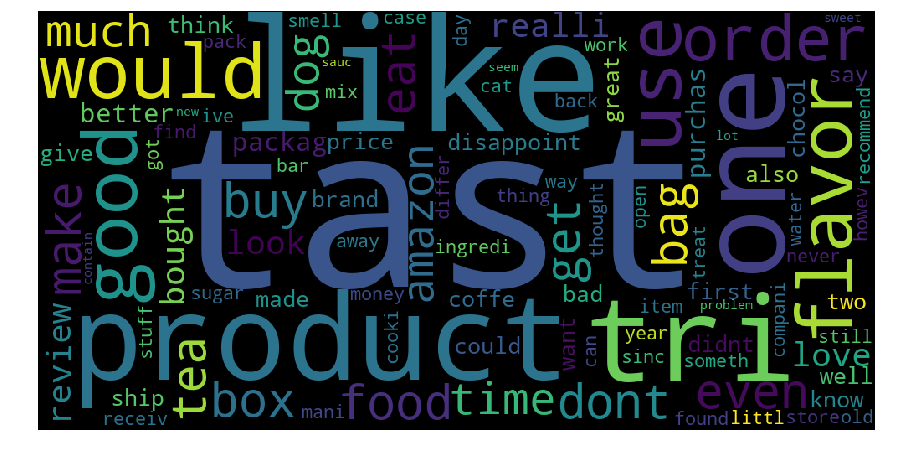

In [58]:
# WordCloud for class 0 
from collections import Counter
from wordcloud import WordCloud
word_could_dict=Counter(negative_100_features)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off") 
plt.show()


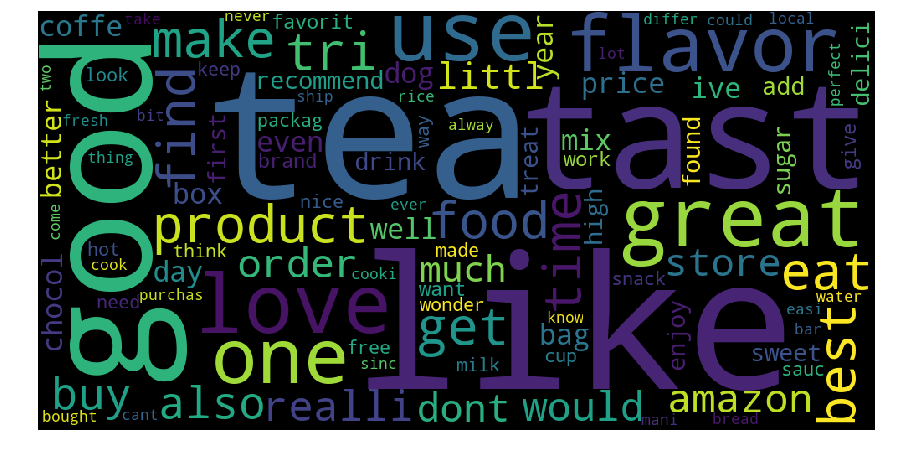

In [59]:
# WordCloud for class 1
word_could_dict=Counter(positive_100_features)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off") 
plt.show()

### Perform Naive Bayes using tf-idf and calculate 'alpha'

In [60]:
X_1=X[:math.ceil(len(final)*.8)]
y_1=y[:math.ceil(len(final)*.8)]
X_test=X[math.ceil(len(final)*.8):]
y_test=y[math.ceil(len(final)*.8):]

print(X_1.shape,y_1.shape,X_test.shape)

(80000,) (80000,) (20000,)


In [61]:
X_train=X_1[:math.ceil(len(final)*.6)]
y_train=y_1[:math.ceil(len(final)*.6)]
X_CV=X_1[math.ceil(len(final)*.6):]
y_CV=y_1[math.ceil(len(final)*.6):]

print(X_train.shape,y_train.shape,X_CV.shape)

(60000,) (60000,) (20000,)


In [62]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
X_train = tf_idf_vect.fit_transform(X_train)

In [63]:
X_test=tf_idf_vect.transform(X_test)
X_CV=tf_idf_vect.transform(X_CV)

In [64]:
X_train

<60000x890239 sparse matrix of type '<class 'numpy.float64'>'
	with 3896792 stored elements in Compressed Sparse Row format>

In [65]:
cv_scores = []

   
for k in neighbors:
    nb = MultinomialNB(alpha=k)
     # fitting the model on crossvalidation train
    nb.fit(X_train, y_train)
    # predict the response on the crossvalidation train
    pred = nb.predict(X_CV)
     # evaluate CV accuracy
    f1_value = f1_score(y_CV, pred, average='weighted') * float(100)
    cv_scores.append(f1_value)
    print('\nCV F1-Scores for alpha = %f is %d%%' % (k, f1_value))


CV F1-Scores for alpha = 0.001000 is 82%

CV F1-Scores for alpha = 0.010000 is 84%

CV F1-Scores for alpha = 0.100000 is 77%

CV F1-Scores for alpha = 1.000000 is 74%

CV F1-Scores for alpha = 10.000000 is 74%

CV F1-Scores for alpha = 100.000000 is 74%

CV F1-Scores for alpha = 1000.000000 is 74%


In [66]:
MSE = [100 - x for x in cv_scores]

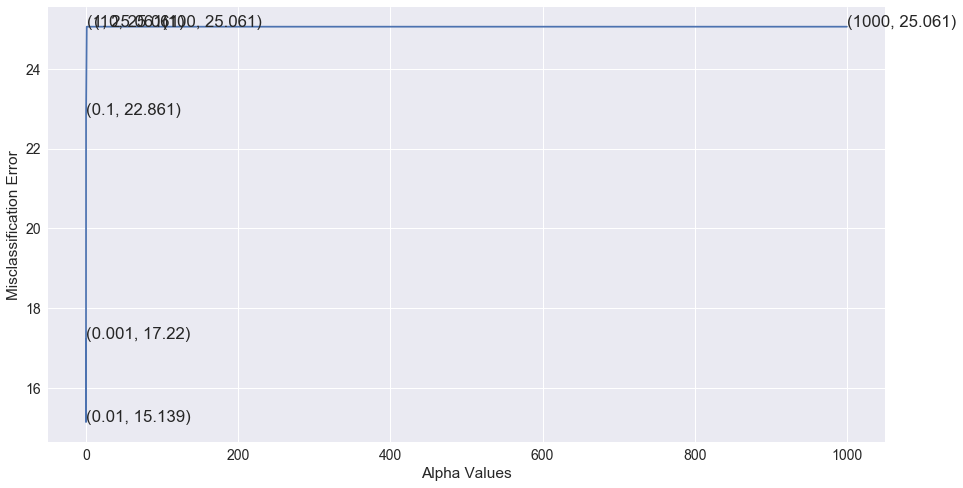

the misclassification error for each alpha value is :  [ 17.22   15.139  22.861  25.061  25.061  25.061  25.061]


In [70]:
plt.figure(figsize=(15,8))
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Alpha Values')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each alpha value is : ", np.round(MSE,3))

In [71]:
optimal_alpha = neighbors[MSE.index(min(MSE))]
print('\nThe optimal value of alpha is %f.' % optimal_alpha)


The optimal value of alpha is 0.010000.


In [72]:
nb = MultinomialNB(alpha=optimal_alpha)
nb.fit(X_train, y_train)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [73]:
pred = nb.predict(X_test)

In [99]:
f1_value = f1_score(y_test, pred, average='weighted') * 100
print('\nThe F1-Score of the nb classifier for alpha = %f is %f%%' % (optimal_alpha, f1_value))


The F1-Score of the nb classifier for alpha = 0.010000 is 83.877306%


In [76]:
array=confusion_matrix(y_test, pred)

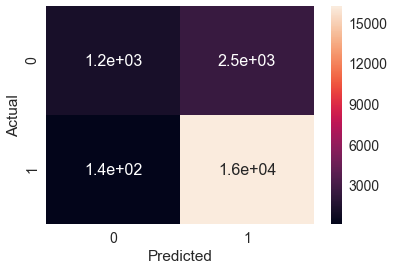

In [77]:
df_cm = pd.DataFrame(array, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### confusion matrix described

In above confusion matrix(used to describe performence of classifier)

* tn(true negative) = 1200, tp(true positive) = 16000, fn(false negative) = 140, fp(false positive) = 2500
* precision --> When it predicts +ve, how often is it correct? = tp/predicted +ve = 16000/18500 = ~86.4%
* True Positive rate(tpr)/recall --> When it is actually +ve, how often does it predict +ve? = tp/(real/true/actual +ve) = 16000/16140 = ~99.1%
* Specificity(True Negative Rate)--> When it's actually no, how often does it predict no? = tn/actual negative = 1200/3700 = ~32.4%.
* False Positive rate --> when it is actually -ve, how often does it predicted +ve = fp/actual-ve = 2500/3700 = ~67.5%

### Feature importance for both +ve and -ve class 

In [78]:
X1=X_train
X1

<60000x890239 sparse matrix of type '<class 'numpy.float64'>'
	with 3896792 stored elements in Compressed Sparse Row format>

In [79]:
y1=new_final['Actual_Score']
y1=y1[:60000]

In [80]:
all_features=tf_idf_vect.get_feature_names()
all_nd1_features=np.array(all_features)

In [81]:
clf1=MultinomialNB(alpha=optimal_alpha)

In [82]:
clf1.fit(X1,y1)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [83]:
neg_class_prob_sorted = (clf1.feature_log_prob_[0, :])

In [84]:
negative_dict=dict(zip(all_nd1_features,neg_class_prob_sorted))

In [85]:
pos_class_prob_sorted = (clf1.feature_log_prob_[1, :])

In [86]:
positive_dict=dict(zip(all_nd1_features,pos_class_prob_sorted))

In [87]:
negative_100_features=sorted(negative_dict, key=negative_dict.get, reverse=True)[:100]

In [88]:
positive_100_features=sorted(positive_dict, key=positive_dict.get, reverse=True)[:100]

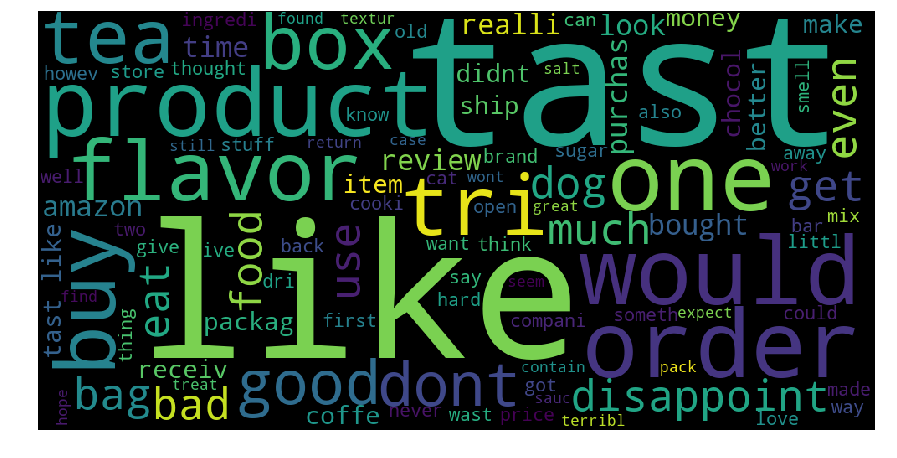

In [89]:
# WordCloud for class 0
word_could_dict=Counter(negative_100_features)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off") 
plt.show()

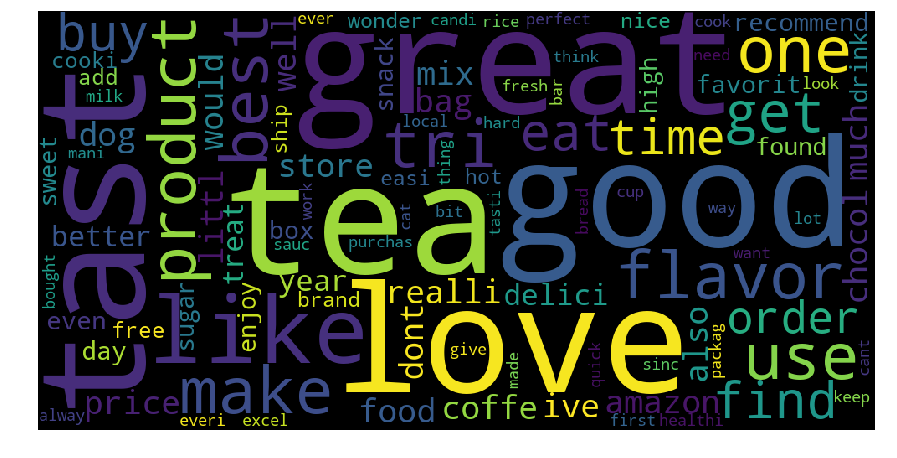

In [90]:
# WordCloud for class 1
word_could_dict=Counter(positive_100_features)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off") 
plt.show()

In [94]:
from prettytable import PrettyTable
    
x = PrettyTable()

In [95]:
x.field_names = ["Vectorization_Technique", "Best alpha", "Precision(%)", "Recall(%)", "F1 Score"]

In [96]:
x.add_row(["BOW", 0.10 ,92.5, 92.20, 0.875 ])

In [97]:
x.add_row(["tf-idf", 0.01, 86.4, 99.1, 0.838])

In [98]:
print(x)

+-------------------------+------------+--------------+-----------+----------+
| Vectorization_Technique | Best alpha | Precision(%) | Recall(%) | F1 Score |
+-------------------------+------------+--------------+-----------+----------+
|           BOW           |    0.1     |     92.5     |    92.2   |  0.875   |
|          tf-idf         |    0.01    |     86.4     |    99.1   |  0.838   |
+-------------------------+------------+--------------+-----------+----------+


### Conclusion

Based on the above technique we may conclude that BoW Vectorization technique works well as compared to tf-idf technique.